## Key Insights:
- Batch size affects quality of learning.
- Without an activation function cost just diverges.
- Even the last deconvolution requires activation
- Need to threshold results at > 0.1 for each channel to visualize correctly or too many channels appear active (conside pixels that are dark across all channels, argmax will still make one of the pixels the winner ( Do we need an extra channel in the training labels for background)
- Also need to apply argmax becasue in keeping with the spirit of softmax each pixel should belong to exactly one class
- Skip connections might be necessary

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.core.framework import graph_pb2
from sklearn.metrics import jaccard_similarity_score

/home/farhanhubble/anaconda3/envs/dl-tflow-src/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X = np.load('combined.npy')
y = np.load('segmented.npy')

In [3]:
SEGMENTATION_TYPE = ['ALL_DIGITS', 'BINARY'][0]
if SEGMENTATION_TYPE is 'BINARY':
    num_classes = 2
    # Collapse per-pixel labels into digit vs non-digit.
    y = np.max(y,axis=3)
    y=np.stack((y==1,y==0),axis=-1)
elif SEGMENTATION_TYPE is 'ALL_DIGITS':
    num_classes = 10


In [4]:
print(X.shape, y.shape)

(5000, 64, 84) (5000, 64, 84, 10)


In [5]:
#Shuffle
X,y = shuffle(X,y)

X = X.astype(np.float32)
y = y.astype(np.float32)

In [6]:
# Normalize
X -= 127.0
X /= 127.0

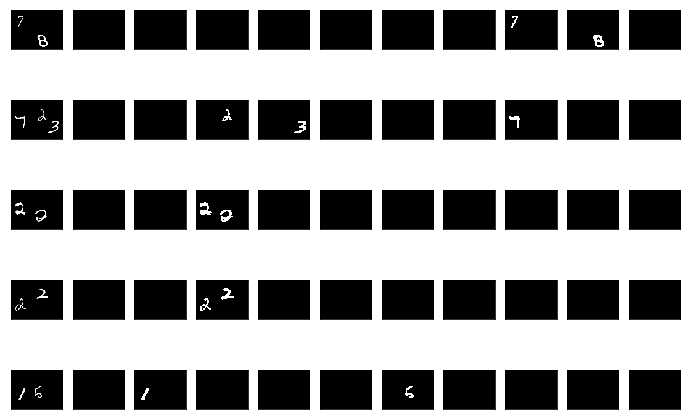

In [7]:
#Plot random examples.
def plot_grid(X_plot, y_plot):

    fig = plt.figure(figsize=(12,8))

    for index, (x_, y_) in enumerate(zip(X_plot, y_plot)):
        ax = plt.subplot2grid((len(X_plot),y_plot[0].shape[-1]+1), (index,0), fig=fig, xticks=[], yticks=[])
        ax.imshow(x_, cmap='gray', vmin=0, vmax=1)
        #plt.show()
        for i in range(y_.shape[-1]):
            ax = plt.subplot2grid((len(X_plot),y_plot[0].shape[-1]+1), (index,i+1), fig=fig, xticks=[], yticks=[] )
            ax.imshow(y_[:,:,i], cmap='gray', vmin=0, vmax=1)
    plt.show()

indices = np.random.randint(low=0, high=len(X), size=5)
plot_grid(X[indices], y[indices])
  

In [8]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

In [9]:
def get_next_batch(batch_size, X, y):
    for start in range(0,len(y),batch_size):
        end = min(len(y), start+batch_size)
        yield X[start:end] , y[start:end]

In [10]:
def load_graph(path_protobuf):
    with open(path_protobuf, "rb") as f:
        graph_def = graph_pb2.GraphDef()
        graph_def.ParseFromString(f.read())
        with tf.Graph().as_default() as graph:
            # Createa new placeholder
            input_big = tf.placeholder(dtype=tf.float32, shape=(None, X.shape[1],X.shape[2],1), name='input_image_big')
            # Import the graph and replace the reshape node with new placeholder.
            tf.import_graph_def(graph_def, name="", input_map={"reshaped_image": input_big})
            return graph

In [31]:
def nn(nb_classes):
    ## Helper functions to reduce clutter.
    _conv1x1 = lambda tensor, nb_filters :\
     tf.layers.conv2d(tensor, 
                    nb_filters, 
                    1, 
                    1,
                    activation=tf.nn.relu)

    _upsample = lambda tensor, kernel_sz, stride, nb_filters :\
     tf.layers.conv2d_transpose(tensor, 
                                nb_filters, 
                                kernel_sz, 
                                stride,
                                activation=tf.nn.relu)

    # Get all required tensors from our pretrained decoder(CNN).
    encoder = load_graph('checkpoints/frozen_graph.pb')
    with encoder.as_default():
        input_ph = encoder.get_tensor_by_name('input_image_big:0')
        maxpool1_out = encoder.get_tensor_by_name('pool1/MaxPool:0')
        maxpool2_out = encoder.get_tensor_by_name('poool2/MaxPool:0')

        enc_l1 = _upsample(maxpool2_out,2,1,128) 
        enc_l2 = _upsample(enc_l1,2,1,128)
        enc_l3 = _upsample(enc_l2,2,2,64)
        enc_l4 = _upsample(enc_l3,2,2,32)
        # Reduce number of channels to number of outputs.
        enc_l5 = _conv1x1(enc_l4,nb_classes)

        # Pixel-wise softamx prediction with nb_class predictions per pixels
        predictions_softmax_op = tf.identity(tf.nn.softmax(enc_l5), name='predictions_softmax')
        # Thresholded predictions at the natural threshold. The strict inequality ensures that
        # a pixel that has probability 0.1 across channels is classified as belonging to none 
        # instead of belonging to all of the classes!!!
        predictions_thresholded_op = predictions_softmax_op > 0.1
        # Pixel-wise most likely class index
        predictions_argmax_op = tf.argmax(predictions_softmax_op,axis=-1)
        # One hot representation of pixel-wise class index, used for
        # in metrics lile (IoU) and for improved visualization 
        predictions_onehot_op = tf.one_hot(predictions_argmax_op,depth=nb_classes,axis=-1)
        predictions_pretty_op = tf.logical_and(tf.cast(predictions_onehot_op,tf.bool),
                                               predictions_thresholded_op)
        
        
        logits = tf.reshape(enc_l5,[-1,num_classes], name='logits')        
        labels_ph = tf.placeholder(dtype=tf.int32, shape=(None, y.shape[1], y.shape[2], y.shape[3]), name='segmentation_labels')
        lr_ph = tf.placeholder(dtype=tf.float32, name='learning_rate')
        labels_flat = tf.reshape(labels_ph,[-1,num_classes])
        cost_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels_flat, logits=logits))
        
        # Apply an optimizer
        optimizer_op = tf.train.AdamOptimizer(learning_rate=lr_ph).minimize(cost_op)

    # Return the graph along with all operation that may be needed.
    # The graph will be passed to tf.Session() because we have added 
    # new opearations to this graph not the default graph
    return encoder, input_ph, labels_ph, lr_ph, optimizer_op, cost_op, predictions_softmax_op, predictions_thresholded_op, predictions_pretty_op

In [32]:
new_graph, input_ph, labels_ph, lr_ph, optimizer_op, cost_op, prediction_softmax_op, predictions_thresholded_op, predictions_pretty_op = nn(nb_classes=num_classes)

In [33]:
print(prediction_op.shape)

(?, 64, 84, 10)


In [34]:
def eval_cost(cost_op, X, y, batch_sz):
    total_cost = 0
    nb_batches = 0
    for batch_X,batch_y in get_next_batch(batch_size,X,y):
        batch_X = np.expand_dims(batch_X,3)
        feed_dict={input_ph: batch_X, labels_ph: batch_y}
        total_cost += cost_op.eval(feed_dict=feed_dict)
        nb_batches += 1
    return total_cost / nb_batches


def predict(prediction_op, X):
    X_ = np.expand_dims(X,3)
    feed_dict={input_ph: X_}
    result = prediction_op.eval(feed_dict=feed_dict)
    return result

def eval_IoU(prediction_op, X, y, batch_sz):
    nb_batches = 0
    total_iou = 0
    for batch_X, batch_y in get_next_batch(batch_sz,X,y):
        predictions =  predict(prediction_op, batch_X)
        
        # Build intersection and union matrices (NxHxWxC)
        intersection_matrix = np.logical_and(batch_y, predictions).astype(np.float)
        union_matrix = np.logical_or(np.logical_xor(batch_y, predictions),intersection_matrix).astype(np.float) 
        
        # Take mean over miniba
        mean_intersection_matrix = np.mean(intersection_matrix,axis=0)
        mean_union_matrix = np.mean(union_matrix,axis=0)
        
        # Sum up over all dimensions (HxWxC) to get a single value for ntersetion and union.
        value_intersection = np.sum(mean_intersection_matrix)
        value_union = np.sum(mean_union_matrix)
        
        # If union is zero intersection will be zero too and IoU is undefined.
        if value_union is not  0:
            total_iou += value_intersection/value_union
        
        nb_batches += 1
    
    return 100*total_iou/nb_batches


In [35]:
from tqdm import tqdm

epochs = 200
batch_size = 4
learning_rate = 0.001
batches_per_epoch = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)



# Launch the graph
with tf.Session(graph=new_graph) as sess:
    summary_writer = tf.summary.FileWriter('./mnist-fcn',sess.graph)
    summary_writer.flush()
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in tqdm(range(epochs)):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        

        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all training batches
        for x, y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            # Convert x to a 4D Tensor by adding an empty dimension because
            # The placeholder and the convolution layers expect a 4-D Tensor
            # in [N,W,H,C] format.
            x_ = np.expand_dims(x,3)
            _, cost = sess.run([optimizer_op, cost_op], 
                                 feed_dict={input_ph:x_, labels_ph:y, lr_ph:learning_rate})
        
        if (epoch+1) % 25 == 0:
            training_IoU  = eval_IoU(predictions_thresholded_op, X_train_fold, y_train_fold, batch_size)
            valid_IoU  = eval_IoU(predictions_thresholded_op, X_val_fold, y_val_fold, batch_size)
            test_IoU  = eval_IoU(predictions_thresholded_op, X_test, y_test, batch_size)
            print(cost, training_IoU, valid_IoU, test_IoU)
            
#             summary = tf.Summary()
#             summary.value.add(tag="Train Cost", simple_value=training_cost)
#             summary.value.add(tag="Train IoU", simple_value=training_IoU)
#             summary.value.add(tag="Validation IoU", simple_value=valid_IoU)
#             summary.value.add(tag="Test IoU", simple_value=test_IoU)
#             summary_writer.add_summary(summary,epoch+1)
#             summary_writer.flush()

    
    print("Optimization Finished!")
    summary_writer.close()
    # Save the graph structure only.
    # Need to save weights in a checkpoint file separately.
    # The graph structure is saved twice, once as a text file 
    # with extension '.pbtxt' and then as a binary file with 
    # extension '.pb'. This is done for demonstration only.
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist-fcn.pbtxt',
    as_text=True)
    
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './checkpoints/',
    'mnist-fcn.pb',
    as_text=False)
    
    saver = tf.train.Saver()
    saver.save(sess,'./checkpoints/mnist-fcn.ckpt',epoch+1)
    
    result_train = predict(predictions_thresholded_op, X_train[0:10])
    result_test = predict(predictions_thresholded_op, X_test[0:10])
    raw_train = predict(prediction_softmax_op,X_train[0:10])
    raw_test  = predict(prediction_softmax_op,X_test[0:10])

 12%|█▎        | 25/200 [01:46<12:28,  4.28s/it]

0.045911916 51.40856907697307 50.549707286693206 48.212545460993034


 25%|██▌       | 50/200 [03:34<10:42,  4.28s/it]

0.038316708 54.74391902958965 54.04676085554554 49.536855214775315


 38%|███▊      | 75/200 [05:19<08:53,  4.26s/it]

0.044188112 56.989561179254764 55.533649204227906 50.00345432626677


 50%|█████     | 100/200 [07:05<07:05,  4.26s/it]

0.049509652 59.34732523040291 58.29668546857643 50.92663681931822


 62%|██████▎   | 125/200 [08:51<05:19,  4.25s/it]

0.0465923 59.90677923007675 58.6095200465149 50.493233124118156


 75%|███████▌  | 150/200 [10:37<03:32,  4.25s/it]

0.036642842 61.185607790776835 60.510544899447545 50.68470094044407


 88%|████████▊ | 175/200 [12:23<01:46,  4.25s/it]

0.050545685 62.894596001069665 63.70216055002275 51.578854181546184


100%|██████████| 200/200 [14:09<00:00,  4.25s/it]

0.01946282 63.29935740648205 60.954431194241586 50.98661299183838
Optimization Finished!


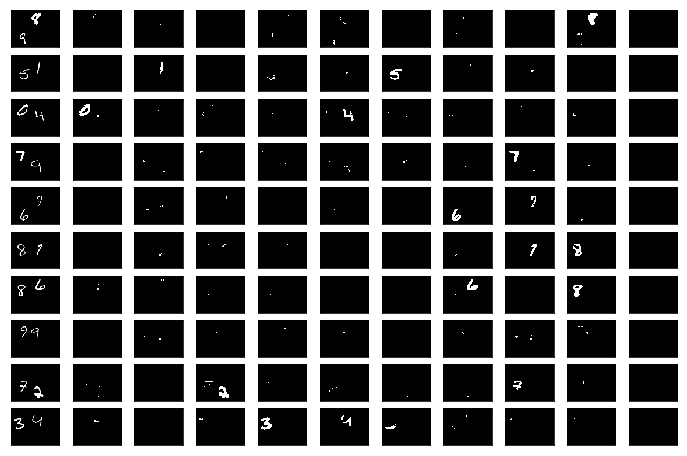

In [ ]:
plot_grid(X_train[0:10],result_train)
plot_grid(X_train[0:10],y_train[0:10])
plot_grid(X_test[0:10], result_test)
plot_grid(X_test[0:10], y_test[0:10])

In [ ]:
a = tf.constant(0,dtype=tf.float32,shape=[1,14,19,1])
b = tf.pad(tf.layers.conv2d_transpose(a,1,2,1),[[0,0],[1,1],[1,1],[0,0]])
c =  tf.pad(tf.layers.conv2d_transpose(b,1,2,2),[[0,0],[2,2],[2,2],[0,0]])
print(b.shape,c.shape)

In [ ]:
a = tf.constant(0,dtype=tf.float32,shape=[1,14,19,1])
b = tf.layers.conv2d_transpose(a,1,2,1)
c = tf.layers.conv2d_transpose(b,1,2,1)
d = tf.layers.conv2d_transpose(c,1,2,2)
e = tf.layers.conv2d_transpose(d,1,2,2)
print(b.shape,c.shape,d.shape, e.shape)

In [ ]:
print(result_train[0,:,:,0])

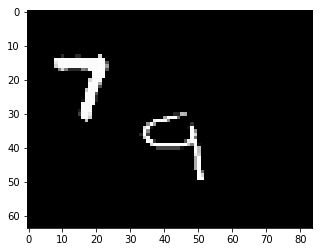

In [30]:
plt.imshow(X_train[3], cmap='gray',vmin=0, vmax=1)

In [ ]:
plt.imshow(np.ones([28,28]), cmap='gray',vmin=0, vmax=1)